# **TadGAN**

Recently, a group of researchers from MIT came up with an idea of Time Series Anomaly Detection using Generative Adversarial Networks(TadGAN)- combining deep learning based approaches and GAN approaches together and developed a benchmarking system for Time Series Anomaly Detection. You can read more about the algorithmic part, here.

In this analysis, we are going to discuss practical implementation of TadGAN through Orion. Orion is a machine learning python-based library for unsupervised time series anomaly detection. This toolkit provides various verified pipelines known as Orion pipelines and uses various AutoML tools developed under DATA TO AI at MIT. Lets dig in!

To read about it more, please refer [this](https://analyticsindiamag.com/hands-on-guide-to-tadgan-with-python-codes/) article.

# **Installing Orion Library**

Easiest way to install is through pip.

In [ ]:

!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn tensorflow keras torch torchvision \
    tqdm scikit-image pmdarima --user -q --no-warn-script-location



In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
# install dependencies then restart kernel and run again
!python -m pip install orion-ml --user -q
!python -m pip install 'urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1' --user -q

# ! git clone https://github.com/signals-dev/Orion.git
#moving all the required modules in current working directory
# ! git clone https://github.com/signals-dev/Orion.git
# ! mv Orion/notebooks/tulog/* .

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

# **Importing required libraries**

Importing all the required modules and functions

In [ ]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#importing sklearn module
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
#utils.py contains all the plot function.
from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

# **Importing the dataset**

The dataset which will be taking,  is NYC taxi dataset. This dataset is maintained by the Numenta community. The full raw version is maintained by The New York City Taxi and Limousine Commission (TLC). The processed dataset contains the demand over a period of 7 months recorded in every 30 minutes.

In [ ]:
#importing data module to load the dataset
from orion.data import load_signal, load_anomalies
#Import nyc_taxi dataset
signal = 'nyc_taxi'
# load_signal function load the given dataset
df = load_signal(signal)
# Since this dataset is already labelled, we will use load_anomalies functions to get all the known anomalies.
known_anomalies = load_anomalies(signal)
df.head(5)

Plotting the dataset with the known anomalies. The blue color represents all the data points and the light pink colored patch represents the known anomaly.


In [ ]:
#the pink-colored patch represent known anomaly
plot(df, known_anomalies)

# **ORION API**

Through this API, we will be doing anomaly detection, using TadGAN model. As stated earlier, there are many pipelines like ARIMA, LSTM, etc, available in Orion, you can use any of them. Our main focus will be TadGAN pipeline. The procedure to use this library is easy as scikit-learn. At first, we train the data using the fit method and to do anomaly detection, we use the detect method. In this case, we will be using the fit_detect method. This process might take some time. Once it is over, it can be easily visualized and results can be seen.

In [ ]:
#importing Orion pipeline
from orion import Orion
#loading the TadGAN pipeline
orion = Orion(pipeline='tadgan.json')
#fitting the data to the TadGAN pipeline of Orion and detecting the outliers.
anomalies = orion.fit_detect(df)

# **Visualize the output**

Let’s plot the result.

In [ ]:
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

# **Tracing Back to the functioning Model**

We have directly passed tadgan.json into the Orion pipeline and abracadabra, we got the results directly. This process is not easy as it seems. If we carefully look into tadgan.json file, we will get to know that it is actually doing multiple processing like data-preprocessing, model training, to post-processing functionalities. As defined by the author, these functions inside this file are called primitives. Each primitive is responsible for a specific task which we will be looking further into this article.

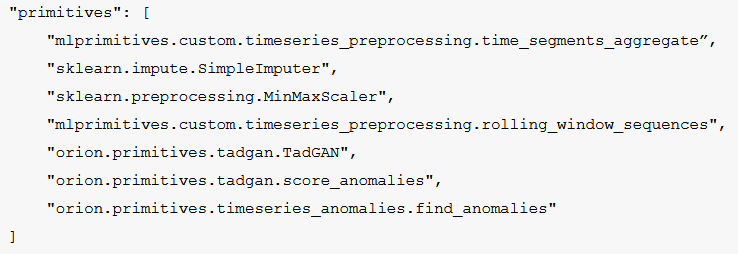

### **Primitives**

In [ ]:
import json
with open("tadgan.json") as f:
  primitives = json.load(f)["primitives"]
print(primitives) 

## **Data Preparation**

### **1. Data Frequency**

In [ ]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    #checking for the input datatype as numpy array and converting it to dataframe
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    #sorting the values on timestamp column and setting it as a index
    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)
#here df is the given dataframe and "timestamp" is the required column to be altered.
X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

### **2. Data Imputation**

In [ ]:
#Using the simple scikit imputer
imp = SimpleImputer()
X = imp.fit_transform(X)

### **3. Data Normalization**

In [ ]:
#Normalizing the data using scikit-learn MinMaxScalar
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

### **4. Data Slicing**

In [ ]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)
#the target value; the value at time t.
#previous observed values, this is determined by the window width.
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [ ]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

In [ ]:
#function from utils.py module. Representing all the windows that has been created by slicing
#Here X represents the input used to train the model. In the previous example, we see X has 10222 training data points.
#Notice that 100 represents the window size. On the other hand, y is the real signal after processing, 
#which we will use later on to calculate the error between the reconstructed and real signal.
plot_rws(X)

## **Training and Detection**

As stated in the Research Paper, the architecture of this model requires four neural networks.

> * encoder: maps X to its latent representation Z.
> * generator: maps the latent variable Z back to X, which we will denote later on as X_hat.
> * criticX: distinguishes between the real time series sequences from X and generated time series from generator(Z) or X_hat.
> * criticZ: measures the performance of the mapping into latent space or in simpler words, it discriminates between Z and encoder(X).

More details of the composition of each network is mentioned in model.py. Specifying all the parameters below, fitting the model to the input X.

In [ ]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 35
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

In [ ]:
# reconstructing the signal
X_hat, critic = tgan.predict(X)
# visualize X_hat
plot_rws(X_hat)

In [ ]:
# flatten the predicted windows 
y_hat = unroll_ts(X_hat)
# plot the time series data 
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

## **Error Computation**

In the TadGAN pipeline, we use tadgan.score_anomalies to perform error calculation. It is a smoothed error function that uses a window based method to smooth the curve then uses either: area, point difference, or dtw as a measure of discrepancy.

> * Area: It captures the general shape of actual and reconstructed signals and then compares them. 
> * Point: It compares each point between the original and reconstructed signal. It is considered as a  strict method and does not allow any mistakes.
> * Dynamic Time Warping (DTW): It compares two signals together using any pairwise distance measure but it allows for one signal to be lagging behind another. A lenient method.

Plotting the error

In [ ]:
from orion.primitives.tadgan import score_anomalies
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)
# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold to classify the high peak data points as anomolous points
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
#now plotting the actual data, known anomalies and predicted anomalies
plot(df, [anomalies, known_anomalies])

In [ ]:
from orion.primitives.timeseries_anomalies import find_anomalies
# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

In [ ]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

# **End-to-End Pipeline Configuration**

In [ ]:
from orion import Orion
#paramter dictionary contains the parameter which are to be overridden.
parameters = {
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1": {
            "interval": 3600 # hour level
        },
    'orion.primitives.tadgan.TadGAN#1': {
        'epochs': 15,
        }
}

orion = Orion(
    'tadgan.json',
    parameters
)

anomalies = orion.fit_detect(df)

In [ ]:
#Plotting the anomalies
plot(df, [anomalies, known_anomalies])

# **Evaluation Methods**

## **Dummy Dataset**

In [ ]:
#Let's assume that the signal starts at timestamp 1, and ends at timestamp 20. 
#We can then see that the ground truth contains three anomalies, namely (5, 8), (12, 13), and (17, 18),
#where (i, j) expresses the starting timestamp i and ending timestamp j.
#We can also see that, we detected two anomalies, namely (5, 8) and (12, 15). So how can we compare both sets?
import numpy as np
# to reproduce the same dummy signal
np.random.seed(0)
# dummy data
start, end = (1, 20)
signal = np.random.rand(end - start, 1)
ground_truth = [
    (5, 8),
    (12, 13),
    (17, 18)
]
anomalies = [
    (5, 8),
    (12, 15)
]

In [ ]:
#plotting the dummy dataset with the anomaly
import matplotlib.pyplot as plt

time = range(start, end)
plt.plot(time, signal)

# ground truth
for i, (t1, t2) in enumerate(ground_truth):
    plt.axvspan(t1, t2+1, color="g", alpha=0.2, label="ground_truth")

# detected
for i, (t1, t2) in enumerate(anomalies):
    plt.axvspan(t1, t2+1, color="r", alpha=0.2, label="detected")

    
plt.title("Example")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

### **Evaluation of dummy dataset through weighted segment**

In [ ]:
#we can use orion.evaluation subpackage to compute multiple metrics using the weighted segment approach. 
#For example to compute the accuracy, we use contextual_accuracy(..., weighted=True). 
#There are other metrics available, for reference checkout the orion.evaluation documentation.
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score
accuracy = contextual_accuracy(ground_truth, anomalies, start=start, end=end)
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end)
print("Accuracy score = {:0.3f}".format(accuracy))
print("F1 score = {:0.3f}".format(f1_score))

### **Evaluation of dummy dataset through overlapping segment**

In [ ]:
#Similarly, we can use the same metric functions, but with parameter weighted=False. 
#Note: overlap segment approach, does not account for true negatives. 
#Reason being, anomalies in time series data are rare and so "normal" instances will skew the value of the computed metric. 
#Therefore, using this approach we cannot compute metrics such as the accuracy. 
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end, weighted=False)
print("F1 score = {:0.3f}".format(f1_score))

## **Pipelin Evaluation End-to-End**

In [ ]:
from orion import Orion
from orion.data import load_signal, load_anomalies
#Importing all the methods for evaluation
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision
metrics = [
    'f1',
    'recall',
    'precision',
]
orion = Orion(
    'tadgan.json'
)
signal = 'nyc_taxi'
# load signal
df = load_signal(signal)
# load ground truth anomalies
ground_truth = load_anomalies(signal)
#Evaluation scores mentioned in the metrics list
scores = orion.evaluate(df, ground_truth, fit=True, metrics=metrics)

In [ ]:
scores

#**Related Articles:**

> * [TadGAN](https://analyticsindiamag.com/hands-on-guide-to-tadgan-with-python-codes/)

> * [Pastas](https://analyticsindiamag.com/guide-to-pastas-a-python-framework-for-hydrogeological-time-series-analysis/)

> * [Bitcoin Price Prediction](https://analyticsindiamag.com/guide-to-implementing-time-series-analysis-predicting-bitcoin-price-with-rnn/)

> * [Time Series Forecasting with Darts](https://analyticsindiamag.com/hands-on-guide-to-darts-a-python-tool-for-time-series-forecasting/)

> * [Guide to Time Series Forecasting with GluonTS](https://analyticsindiamag.com/gluonts-pytorchts-for-time-series-forecasting/)

> * [Tensorflow Core](https://analyticsindiamag.com/time-series-forecasting-using-tensorflow-core/)

